Set up kaggle creditentals.

In [ ]:
import os
import pathlib

DRIVE_PATH = pathlib.Path("/content/drive/MyDrive/brain")
# !pip install -r "/content/drive/MyDrive/brain/requirements.txt"
os.environ["KAGGLE_USERNAME"] = "" # add your username
os.environ["KAGGLE_KEY"] = "" # add your kaggle key

In [ ]:
!python -V

Python 3.10.12


Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downlaod the content of dataset

In [ ]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files("mateuszbuda/lgg-mri-segmentation", path="/content/data", unzip=True, quiet=True)

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation


Split the files to 3 different folder.

Distribution:
*   Test: 5 patients
*   Validation: 10 patients
*   Training: 95 patients





In [ ]:
import pathlib
file_names = sorted(pathlib.Path("/content/data/kaggle_3m").glob("TCGA*"))
train_path = pathlib.Path("/content/data/train")
val_path = pathlib.Path("/content/data/val")
test_path = pathlib.Path("/content/data/test")
train_path.mkdir(exist_ok=True)
val_path.mkdir(exist_ok=True)
test_path.mkdir(exist_ok=True)

for patient in file_names[0:5]:
    patient.rename(test_path / patient.name)
for patient in file_names[5:15]:
    patient.rename(val_path / patient.name)
for patient in file_names[15:-1]:
    patient.rename(train_path / patient.name)


Define the hyperparameters for the whole training process.

In [ ]:
import pathlib
import torch
class HyperParameters():
  BATCH_SIZE = 16
  IMAGE_SIZE = 256
  EPOCHS = 40
  LEARNING_RATE = 0.0002
  WEIGHTS_PATH = DRIVE_PATH

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")


device: cuda:0


Define the transformation.

In [ ]:
from torchvision.transforms import v2
import torch

transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((256, 256)),
])
# TODO: Augemntation may be needed

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Define a dataset and create separated dataset for each phase of learning.

In [ ]:
from typing import NamedTuple
from torch.utils.data import Dataset
import pathlib
import skimage.io
import numpy as np
from torchvision.transforms import v2

class SliceInfo(NamedTuple):
  image: pathlib.Path
  mask: pathlib.Path

class BrainImageDataset(Dataset):
  def __init__(self, path: pathlib.Path, transfrom: v2.Transform) -> None:
    self._slices: list[SliceInfo] = []
    self._transform = transform

    for patient_dir in path.glob("TCGA*"):
      for mask_image in patient_dir.glob("*_mask.tif"):
        image_path = pathlib.Path(mask_image.as_posix().replace("_mask",""))
        slice_info = SliceInfo(image_path, mask_image)
        self._slices.append(slice_info)
    self._slices.sort(key=lambda i: i.image.name)

  def __getitem__(self, index) -> tuple:
    image_path, mask_path = self._slices[index]
    image = skimage.io.imread(image_path)
    mask = skimage.io.imread(mask_path, as_gray=True)

    image = np.array(image)
    mask = np.array(mask)
    info = image_path.name.split("/")[-1]

    image, mask = self._transform(image, mask)
    mask = mask[0,:,:].view((1, 256, 256))
    return image, mask, info

  def __len__(self) -> int:
    return len(self._slices)

train_ds = BrainImageDataset(pathlib.Path("/content/data/train"), transform)
val_ds = BrainImageDataset(pathlib.Path("/content/data/val"), transform)
test_ds = BrainImageDataset(pathlib.Path("/content/data/test"), transform)
print(f"data splitting:\ntrain\t{len(train_ds)}\nval\t{len(val_ds)}\ntest\t{len(test_ds)}")

data splitting:
train	3505
val	233
test	103


Helper functions to visualize the data and the result.

In [ ]:
from operator import imod
import matplotlib.pyplot as plt
import matplotlib.patches
import torch
import torch.nn as nn

def show_image(image_ds: BrainImageDataset, index: int) -> None:
    plt.imshow(np.squeeze(image_ds[index][0]).T)
    plt.title(image_ds[index][2])

def show_mask(image_ds: BrainImageDataset, index: int) -> None:
    plt.imshow(np.squeeze(image_ds[index][1]).T, cmap="gray")
    plt.title(image_ds[index][2])

def show_prediction(image_ds: BrainImageDataset,
                    index: int,
                    net: nn.Module,
                    threshold=0.8) -> None:
    fig, ax = plt.subplots(2, 2)

    ax[0, 0].imshow(np.squeeze(image_ds[index][0]).T)
    ax[0, 0].set_title(image_ds[index][2])
    _remove_ticklabels(ax[0, 0])

    true = np.squeeze(image_ds[index][1]).T
    ax[0, 1].imshow(true, cmap="gray")
    ax[0, 1].set_title("ground truth")
    _remove_ticklabels(ax[0, 1])

    x = image_ds[index][0].view((1,3,256,256)).to(device)
    with torch.no_grad():
        preds = net(x)
    prediction = preds.detach().cpu().numpy()
    prediction = np.squeeze(prediction[0]).T
    ax[1, 0].imshow(prediction, cmap="gray")
    ax[1, 0].set_title("prediction")
    _remove_ticklabels(ax[1, 0])

    empty_image_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    for i in range(0, 256):
      for j in range(0, 256):
        if true[i, j] > 0.5:
          empty_image_rgb[i, j, 0] = 255
        if prediction[i, j] > threshold:
          empty_image_rgb[i, j, 1] = 255


    ax[1, 1].imshow(empty_image_rgb)
    ax[1, 1].set_title("prediction overlay")
    ax[1, 1].text(-120, 20, "ground truth", color="red", fontsize=8)
    ax[1, 1].text(-120, 35, "prediction", color="green", fontsize=8)
    ax[1, 1].text(-120, 50, "overlay", color="yellow", fontsize=8)
    _remove_ticklabels(ax[1, 1])

def show_segmentation(
    image_ds: BrainImageDataset,
    index: int,
    net: nn.Module,
    threshold=0.8
):
    image_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    brain_image = np.squeeze(image_ds[index][0]).T
    brain_mask = np.squeeze(image_ds[index][1]).T
    input = image_ds[index][0].view((1,3,256,256)).to(device)
    with torch.no_grad():
        preds = net(input)
    prediction = preds.detach().cpu().numpy()
    prediction = np.squeeze(prediction[0]).T
    image_rgb[:, :, 0] = brain_image[:, :, 1] * 255
    image_rgb[:, :, 1] = brain_image[:, :, 1] * 255
    image_rgb[:, :, 2] = brain_image[:, :, 1] * 255

    for i in range(0, 256):
        for j in range(0, 256):
            _draw_outline(brain_mask, image_rgb, i, j, color="red")
            _draw_outline(prediction, image_rgb, i, j, color="green", th=threshold)

    im = plt.imshow(image_rgb)

    plt.title(image_ds[index][2])
    colors = ["red", "green", "yellow"]
    values = ["mask", "prediction", "perfect fit"]
    patches = [ matplotlib.patches.Patch(color=colors[i], label=values[i]) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def _remove_ticklabels(ax) -> None:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

def _draw_outline(mask, output, i ,j, color, th=0.5):
    channel = 0
    if color == "green":
        channel = 1
    if color == "blue":
        channel = 2
    if mask[i, j] > th:
        if i == 0 or j == 0 or i == 255 or j == 255:
            output[i, j, channel] = 255
        elif (mask[i-1, j] < th or mask[i+1, j] < th or
              mask[i, j-1] < th or mask[i, j+1] < th):
            output[i, j, channel] = 255


Dataloaders

In [ ]:
import torch
from torch.utils.data import DataLoader

train_dl = DataLoader(dataset=train_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=True)

test_dl = DataLoader(dataset=test_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=False)

val_dl = DataLoader(dataset=val_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=False)

Define a model for the image segmentation.

In [ ]:
import collections
import torch
import torch.nn as nn

class BrainSegmentationModel(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    features = 32
    self.encoder1 = BrainSegmentationModel._block(3, features, name="enc1")
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder2 = BrainSegmentationModel._block(features, features * 2, name="enc2")
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder3 = BrainSegmentationModel._block(features * 2, features * 4, name="enc3")
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder4 = BrainSegmentationModel._block(features * 4, features * 8, name="enc4")
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.bottleneck = BrainSegmentationModel._block(features * 8, features * 16, name="bottleneck")

    self.upconv4 = nn.ConvTranspose2d(
        features * 16, features * 8, kernel_size=2, stride=2
    )
    self.decoder4 = BrainSegmentationModel._block((features * 8) * 2, features * 8, name="dec4")
    self.upconv3 = nn.ConvTranspose2d(
        features * 8, features * 4, kernel_size=2, stride=2
    )
    self.decoder3 = BrainSegmentationModel._block((features * 4) * 2, features * 4, name="dec3")
    self.upconv2 = nn.ConvTranspose2d(
        features * 4, features * 2, kernel_size=2, stride=2
    )
    self.decoder2 = BrainSegmentationModel._block((features * 2) * 2, features * 2, name="dec2")
    self.upconv1 = nn.ConvTranspose2d(
        features * 2, features, kernel_size=2, stride=2
    )
    self.decoder1 = BrainSegmentationModel._block(features * 2, features, name="dec1")

    self.conv = nn.Conv2d(
        in_channels=features, out_channels=1, kernel_size=1
    )

  def forward(self, x):
      enc1 = self.encoder1(x)
      enc2 = self.encoder2(self.pool1(enc1))
      enc3 = self.encoder3(self.pool2(enc2))
      enc4 = self.encoder4(self.pool3(enc3))

      bottleneck = self.bottleneck(self.pool4(enc4))

      dec4 = self.upconv4(bottleneck)
      dec4 = torch.cat((dec4, enc4), dim=1)
      dec4 = self.decoder4(dec4)
      dec3 = self.upconv3(dec4)
      dec3 = torch.cat((dec3, enc3), dim=1)
      dec3 = self.decoder3(dec3)
      dec2 = self.upconv2(dec3)
      dec2 = torch.cat((dec2, enc2), dim=1)
      dec2 = self.decoder2(dec2)
      dec1 = self.upconv1(dec2)
      dec1 = torch.cat((dec1, enc1), dim=1)
      dec1 = self.decoder1(dec1)
      return torch.sigmoid(self.conv(dec1))

  @staticmethod
  def _block(in_channels, features, name):
      return nn.Sequential(
          collections.OrderedDict(
              [
                  (
                      name + "conv1",
                      nn.Conv2d(
                          in_channels=in_channels,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm1", nn.BatchNorm2d(num_features=features)),
                  (name + "relu1", nn.ReLU(inplace=True)),
                  (
                      name + "conv2",
                      nn.Conv2d(
                          in_channels=features,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm2", nn.BatchNorm2d(num_features=features)),
                  (name + "relu2", nn.ReLU(inplace=True)),
              ]
          )
      )

Layer information of the model

In [ ]:
!pip install torch-summary
from torchsummary import summary
summary(BrainSegmentationModel(), (3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        864
|    └─BatchNorm2d: 2-2                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        9,216
|    └─BatchNorm2d: 2-5                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-6                         [-1, 32, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 32, 128, 128]        --
├─Sequential: 1-3                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,432
|    └─BatchNorm2d: 2-8                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-9                         [-1, 64, 128, 128]        --
|    └─Conv2d: 2-10                      [-1, 64, 128, 128]        36,864
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        864
|    └─BatchNorm2d: 2-2                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        9,216
|    └─BatchNorm2d: 2-5                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-6                         [-1, 32, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 32, 128, 128]        --
├─Sequential: 1-3                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,432
|    └─BatchNorm2d: 2-8                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-9                         [-1, 64, 128, 128]        --
|    └─Conv2d: 2-10                      [-1, 64, 128, 128]        36,864
| 

Load a previously saved model (Optional)

In [ ]:
import torch
net = BrainSegmentationModel()
if device == "cuda:0":
    net.load_state_dict(torch.load(HyperParameters.WEIGHTS_PATH / "separated3UNet.pt", weights_only=True))
else:
    net.load_state_dict(torch.load(HyperParameters.WEIGHTS_PATH / "separated3UNet.pt", map_location=torch.device('cpu'), weights_only=True))
net.to(device)
print("Model loaded")

Model loaded


Define lossses for the segmentation.

In [ ]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size(), f"pred: {y_pred.size()}, true: {y_true.size()}"
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2.0 * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1.0 - dsc

class IoULoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum() - intersection
        iou = union / (intersection + self.smooth)
        return 1.0 - iou

Initialize the network, loss and optimizer.

In [ ]:
import torch

net = BrainSegmentationModel()
net = net.to(device)

loss_func = DiceLoss()
loss_func = loss_func.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=HyperParameters.LEARNING_RATE)

Helper function for training.

In [ ]:
def log_summary(loss_list: list[float], prefix=""):
    print(f"{prefix}loss: {np.mean(loss_list)}\n")

def add_loss_by_patient(loss_valid: dict[str, list[float]],
                        info: list[str],
                        loss_func: nn.Module,
                        y_pred: list[torch.Tensor],
                        y_true: list[torch.Tensor]):
    for i, patient in enumerate(info):
            patient_id = patient.split("_")[2]
            if patient_id not in loss_valid:
                loss_valid.setdefault(patient_id, [])
            loss = loss_func(y_pred[i], y_true[i])
            loss_valid[patient_id].append(loss.detach().cpu().numpy())

Training

In [ ]:
loss_train: dict[str, list[float]] = {}
loss_valid: dict[str, list[float]] = {}
history: dict[str, list[float | dict]] = {"train": [], "valid": [], "model": []}


for epoch in range(HyperParameters.EPOCHS):
    print(f"===== EPOCH {epoch} =====\n")

    # training
    for i, data in enumerate(train_dl):

        x, y_true, info = data
        x, y_true = x.to(device), y_true.to(device)
        net.train()
        optimizer.zero_grad()

        y_pred = net(x)

        loss = loss_func(y_pred, y_true)

        add_loss_by_patient(loss_train, info, loss_func, y_pred, y_true)
        loss.backward()
        optimizer.step()

    # train loss
    patient_loss = []
    for patient in loss_train:
        patient_loss.append(np.mean(loss_train[patient]))
    log_summary(patient_loss, prefix="train_")
    history["train"].append(np.mean(patient_loss))
    loss_train = {}

    # validation
    for i, valid_data in enumerate(val_dl):
        x, y_true, info = valid_data
        x, y_true = x.to(device), y_true.to(device)

        net.eval()
        optimizer.zero_grad()

        with torch.no_grad():
            y_pred = net(x)

        add_loss_by_patient(loss_valid, info, loss_func, y_pred, y_true)

    # valid loss
    patient_loss = []
    for patient in loss_valid:
        patient_loss.append(np.mean(loss_valid[patient]))
    log_summary(patient_loss, prefix="val_")
    history["valid"].append(np.mean(patient_loss))
    history["model"].append(net.state_dict())
    loss_valid = {}

    if (epoch > 3
        and history["valid"][-1] > history["valid"][-2]
        and history["valid"][-1] > history["valid"][-3]
        and history["valid"][-1] > history["valid"][-4]):
        break

best_model = history["valid"].index(min(history["valid"]))
print(f"Best model: {best_model}")
net.load_state_dict(history["model"][best_model])

===== EPOCH 0 =====

train_loss: 0.9796384572982788

val_loss: 0.9637355804443359

===== EPOCH 1 =====

train_loss: 0.9113383293151855

val_loss: 0.8740271329879761

===== EPOCH 2 =====

train_loss: 0.6388319134712219

val_loss: 0.469165176153183

===== EPOCH 3 =====

train_loss: 0.32404452562332153

val_loss: 0.22189116477966309

===== EPOCH 4 =====

train_loss: 0.1675325632095337

val_loss: 0.12999805808067322

===== EPOCH 5 =====

train_loss: 0.09133300185203552

val_loss: 0.08659173548221588

===== EPOCH 6 =====

train_loss: 0.068076953291893

val_loss: 0.050123073160648346

===== EPOCH 7 =====

train_loss: 0.052259501069784164

val_loss: 0.04008714109659195

===== EPOCH 8 =====

train_loss: 0.032081130892038345

val_loss: 0.017300697043538094

===== EPOCH 9 =====

train_loss: 0.02926238253712654

val_loss: 0.019746651872992516

===== EPOCH 10 =====

train_loss: 0.021285662427544594

val_loss: 0.018855014815926552

===== EPOCH 11 =====

train_loss: 0.017092429101467133

val_loss: 0

<All keys matched successfully>

Plot training loss

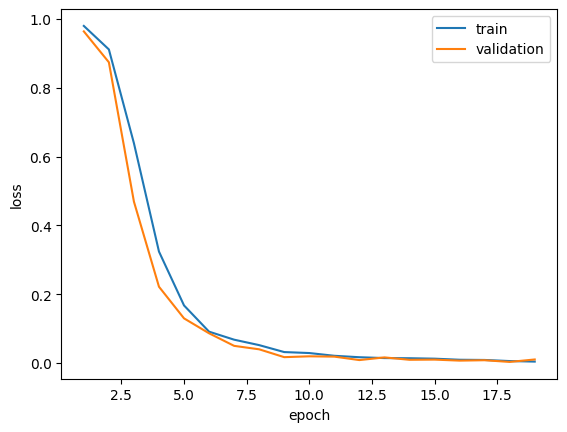

In [ ]:
import matplotlib.pyplot as plt
x_label = [int(x) for x in range(1, len(history["train"]) + 1)]
plt.plot(x_label, history["train"], label="train")
plt.plot(x_label, history["valid"], label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

Calculate the test loss from batch loss and sperately for every test patient.

In [ ]:
dice_loss = DiceLoss()
iou_loss = IoULoss()
loss_dice = []
loss_iou = []
a = 0
test_dice_loss = {}
test_iou_loss = {}
for i, data in enumerate(test_dl):
  x, y_true, info = data
  x, y_true = x.to(device), y_true.to(device)
  with torch.no_grad():
    y_pred = net(x)
    loss_dice.append(dice_loss(y_pred, y_true).detach().cpu().numpy())
    loss_iou.append(iou_loss(y_pred, y_true).detach().cpu().numpy())
    add_loss_by_patient(test_dice_loss, info, dice_loss, y_pred, y_true)
    add_loss_by_patient(test_iou_loss, info, iou_loss, y_pred, y_true)
print(f"One by one loss values: iou loss: {np.mean([np.mean(v) for k,v in test_iou_loss.items()])}, dice loss: {np.mean([np.mean(v) for k,v in test_dice_loss.items()])}")
print(f"batch by batch loss values: iou loss: {np.mean(loss_iou)}, dice loss: {np.mean(loss_dice)}")
assert test_dice_loss.keys() == test_iou_loss.keys()
for patient in test_dice_loss:
    print(f"Patient {patient}: iou loss: {np.mean(test_iou_loss[patient])}, dice loss: {np.mean(test_dice_loss[patient])}")

One by one loss values: iou loss: 0.9892058372497559, dice loss: 0.010677799582481384
batch by batch loss values: iou loss: -0.444134384393692, dice loss: 0.17310728132724762
Patient 4941: iou loss: 0.9883145093917847, dice loss: 0.011548511683940887
Patient 4942: iou loss: 0.9894507527351379, dice loss: 0.010438576340675354
Patient 4943: iou loss: 0.9890650510787964, dice loss: 0.010816049762070179
Patient 4944: iou loss: 0.9891619682312012, dice loss: 0.010721486993134022
Patient 5393: iou loss: 0.9900371432304382, dice loss: 0.009864374995231628


Find the best threshold value

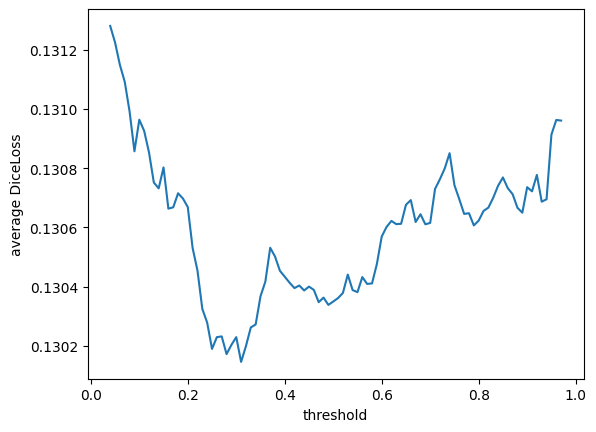

Min loss: 0.1301 at 0.31


In [ ]:
import matplotlib.pyplot as plt
import torch
dice_loss = DiceLoss()
iou_loss = IoULoss()
losses = {"th": [], "loss": []}
for th in np.arange(0.04, 0.98, 0.01):
    loss_dice = []
    loss_iou = []
    test_dice_loss = {}
    test_iou_loss = {}
    for i, data in enumerate(test_dl):
        x, y_true, info = data
        x, y_true = x.to(device), y_true.to(device)
        with torch.no_grad():
            y_pred = net(x)
            y_pred = (y_pred > th).float()
            y_pred = torch.where(y_pred > 0.5, torch.tensor(1.0), torch.tensor(0.0))
            loss_dice.append(dice_loss(y_pred, y_true).detach().cpu().numpy())
            loss_iou.append(iou_loss(y_pred, y_true).detach().cpu().numpy())
            add_loss_by_patient(test_dice_loss, info, dice_loss, y_pred, y_true)
            add_loss_by_patient(test_iou_loss, info, iou_loss, y_pred, y_true)
    losses["th"].append(th)
    losses["loss"].append(np.mean(loss_dice))

plt.figure()
plt.plot(losses["th"], losses["loss"])
plt.xlabel("threshold")
plt.ylabel("average DiceLoss")
plt.show()

min_loss = min(losses["loss"])
print(f"Min loss: {min_loss:.4f} at {losses['th'][losses['loss'].index(min_loss)]:.2f}")


Generate the segmentated data for each test patient.

<ipython-input-7-c7cc3895bbae>:62: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  brain_image = np.squeeze(image_ds[index][0]).T


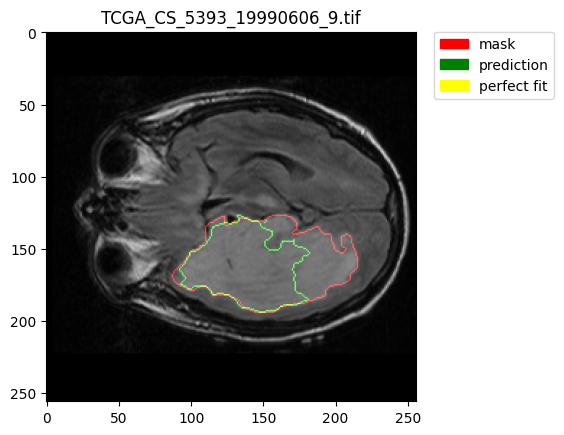

In [ ]:
import pathlib
for i, data in enumerate(test_ds):
    show_segmentation(test_ds, i, net, threshold=0.31)
    n = data[2].split("_")
    folder = pathlib.Path(HyperParameters.WEIGHTS_PATH) / n[3]
    folder.mkdir(exist_ok=True)
    plt.savefig(folder / n[4], dpi=300, bbox_inches="tight")

Saving model to the path defined in the hyperparameters.

In [ ]:
torch.save(net.state_dict(), HyperParameters.WEIGHTS_PATH / "UNet.pt")